# <div style="color:white;display:fill;border-radius:5px;background-color:#c0c0c0;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:200%;letter-spacing:0.5px;margin:0"> Kolmogorov-Smirnov test</p></div>



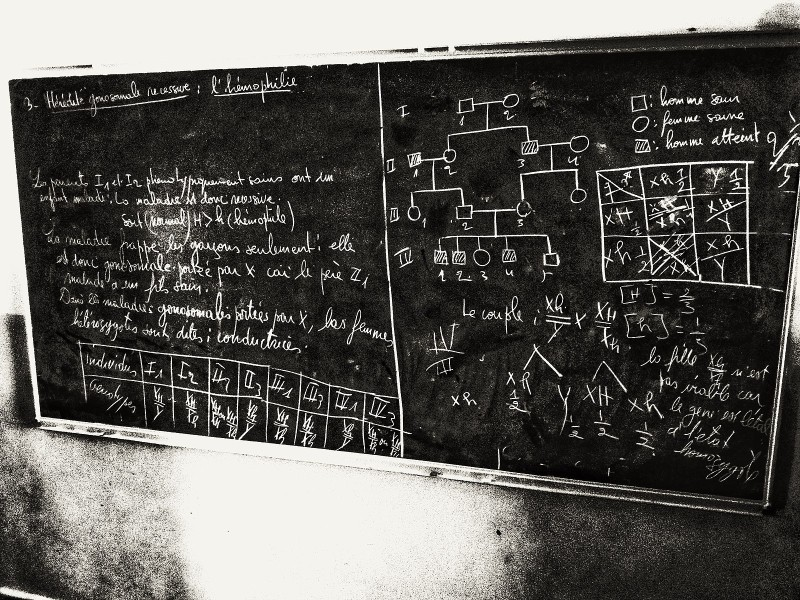

# <div style="color:white;display:fill;border-radius:5px;background-color:#E3B663;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="NEW"></a><p style="padding:20px;color:BLACK;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> How to correctly sample a huge dataset?</p></div>
[back](#TOC)





# This month competition is quite hard for most of the tree classifier and quite memory consuming. 
# What if we are able to sample a DataFrame randomically but in a way that makes sense? I mean in a way that is representative of the data?
# We will try to do it with the Kolmogorov-Smirnov test

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="TOC"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Table of contents</p></div>


1. [Imports](#Imports)
2. [Dataset](#Dataset) 
3. [Kolmogorov-Smirnov test](#KST)
4. [New DataFrame](#NEW)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Imports"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Imports</p></div>
[back](#TOC)

In [ ]:
## Basic packages
import os, gc, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 8)



In [ ]:
# Kolmogorov-Smirnov test
from scipy.stats import ks_2samp

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Dataset"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Dataset</p></div>
[back](#TOC)

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv').set_index("row_id")
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv').set_index("row_id")

sample_submission = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

In [ ]:
len(train), len(train.columns), train['target'].nunique()

The DataFrame has 200000 rows by 286 columns and ten targets.

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="KST"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Kolmogorov-Smirnov test</p></div>
[back](#TOC)





In a few words, we want to know if our new sampled DataFrame has the same distribution as the original and if **it's statistically significant**

I can suggest a quick read [Kolmogorov-Smirnov Test for Normality](https://www.spss-tutorials.com/spss-kolmogorov-smirnov-test-for-normality/)
and a second article [How to correctly select a sample from a huge dataset in machine learning](https://www.kdnuggets.com/2019/05/sample-huge-dataset-machine-learning.html#:~:text=Take%20one%20variable%20from%20the,Repeat%20with%20all%20the%20variables)

The basic idea is that this test computes a number called P.VALUE, if this value is below 5% or 0.05, the population of the sampled data doesn't represent the original data; if it's above, it does

<b><span style='color:#ae0f09;font-size:200%'>1 | </span> 
</b>To reach our goal we are going initially to divide our Dataframe by targets, e.g.: Streptococcus_pyogenes, Salmonella_enterica, etc...

In [ ]:
train.target.unique()

In [ ]:
#create a specific df with a target column and a target label number i to be iterated
def sub_train_df_col(df,target_col,i):#input df, target column, target number
    tgt_types = df[target_col].unique() # check the target column values
    sub_df = df[df[target_col]==tgt_types[i]]# creates a new df with the single target
    return sub_df, target_col, tgt_types[i]# returns the new df, the target column name, the target name



In [ ]:
df1, target_col, tgt_type = sub_train_df_col(train,'target',1)
print("target column: " + str(target_col))
print("target selected: " + tgt_type)
print("number of samples:" + str(len(df1)))
df1.head(3)

<b><span style='color:#ae0f09;font-size:200%'>2 | </span> 
</b>Then we are going to subsample it.

In [ ]:
# creates a sample from the df
def sub_train_df_sample(df,tgt_type,fraction):
    sub_train_sample = df.sample(frac=fraction) # sub samples the df to fraction, usually 10%
    print("sub sample "+tgt_type+": "+str(len(sub_train_sample))) 
    return sub_train_sample

In [ ]:
fraction = 0.1 # 10% of the original data
df2 = sub_train_df_sample(df1,tgt_type,fraction) 

the result of the subsample tell us wich target and how many samples. In this case the target is Salmonella Enterica and there are 2003 samples.

<b><span style='color:#ae0f09;font-size:200%'>3 | </span> 
</b>... And we are going to run the Kolmogorov-Smirnov test.

In [ ]:
# test to check if the columns are representative
def check_kst(df1,df2,kst_pval):
    test = False
    for col in range(len(df1.columns)):
        #perform Kolmogorov-Smirnov test
        kst = ks_2samp(df1.iloc[:,col], df2.iloc[:,col])
        if kst[1] < kst_pval:
            print("column "+ df1.columns[col]+": "+str(kst[1])) # checks how goos is the subsample
            test=True
            break
            
    return test

In [ ]:
kst_pval = 0.1 # minimum Kolmogorov-Smirnov P.VALUE that we want for the test.
                # 0.05 is the minimun acceptable.
check_kst(df1,df2,kst_pval)

the result that appears shows wich column doesn't pass the test and what is the value.
When the test is passed for each column of the subsampled DataFrame a new DataFrame is created and we repeat the process for all the targets.


<b><span style='color:#ae0f09;font-size:200%'>4 | </span> 
</b>Here below the full code to create the DataSet.

In [ ]:
#create a specific df with a target column and a target label number i to be iterated
def sub_train_df_col(df,target_col,i):#input df, target column, target number
    tgt_types = df[target_col].unique() # check the target column values
    sub_df = df[df[target_col]==tgt_types[i]]# creates a new df with the single target
    return sub_df, target_col, tgt_types[i]# returns the new df, the target column name, the target name

#df1, target_col, tgt_type = sub_train_df_col(train,'target',1)


# creates a sample from the df
def sub_train_df_sample(df,tgt_type,fraction):
    sub_train_sample = df.sample(frac=fraction) # sub samples the df to fraction, usually 10%
    print("sub sample "+tgt_type+": number of samples "+str(len(sub_train_sample))) 
    return sub_train_sample
    
#df2 = sub_train_df_sample(df1,tgt_type,fraction) 


# test to check if the columns are representative
def check_kst(df1,df2,kst_pval):
    test = False
    for col in range(len(df1.columns)):
        #perform Kolmogorov-Smirnov test
        kst = ks_2samp(df1.iloc[:,col], df2.iloc[:,col])
        if kst[1] < kst_pval:
            print("column "+ df1.columns[col]+": p.value = "+str(kst[1])) # checks how goos is the subsample
            print("below the set min P.value of "+str(kst_pval)+" -> resampling")
            test=True
            break
            
    return test

#check_kst(df1,df2,kst_pval)


def create_df_col_kst_checked(df1,tgt_type,fraction,kst_pval,max_sample):
    test = True
    print(test)
    sample=0
    while (test & (sample < max_sample)) :
        df2 = sub_train_df_sample(df1,tgt_type,fraction) 
        test = check_kst(df1,df2,kst_pval)
        sample+=1
        print("sample "+str(sample))
        if test==False:
          print("FOUND! FOUND! FOUND!")
    else:
        if (sample == max_sample):
          print("MAX sample reached!!!, consider changing params!!!")
    return df2, test
    
#df3 = create_df_col_kst_checked(df1,tgt_type,fraction,kst_pval,max_sample)

def create_kst_df(df,target_col,fraction=0.1,kst_pval=0.1,max_sample=100):
    
    new_df = pd.DataFrame()
    
    for i in range(df[target_col].nunique()):
        df1, target_col, tgt_type = sub_train_df_col(df,target_col,i)
        df3,test = create_df_col_kst_checked(df1,tgt_type,fraction,kst_pval,max_sample)
        new_df = new_df.append(df3)
    return new_df



<b><span style='color:#ae0f09;font-size:200%'>5 | </span> 
</b>Compute

# <div style="color:white;display:fill;border-radius:5px;background-color:#E3B663;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="NEW"></a><p style="padding:20px;color:BLACK;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> I urge you to play with the fraction, the kst_pval and the max_sample to better understand the process here below.</p><p style="padding:20px;color:BLACK;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0">You will find out that some targets don't want to sub sample too much, while others can be made very small.    Enjoy the process ...</p></div>
[back](#TOC)





In [ ]:
kst_df = create_kst_df(df=train,target_col='target',fraction=0.05,kst_pval=0.1,max_sample=100)

# <div style="color:white;display:fill;border-radius:5px;background-color:#E3B663;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="NEW"></a><p style="padding:20px;color:BLACK;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> And here we have it ... a BRAND NEW SMALL SIGNIFICANT DATAFRAME</p></div>
[back](#TOC)





Now we can use it for our decision tree algos or to create many small "significant" DataFrame

In [ ]:
kst_df

10000 rows x 287 columns

In [ ]:
kst_df.target.nunique(),kst_df.target.unique()

In [ ]:
# save it
kst_df.to_csv('new_df.csv')

# <div style="color:white;display:fill;border-radius:5px;background-color:#E3B663;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id=""></a><p style="padding:20px;color:BLACK;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> I hope that the results are self explanatory, If you have any question or suggestions please post it on the [discussion](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/307759) that I created.  </p><p style="padding:20px;color:BLACK;overflow:hidden;font-size:200%;letter-spacing:0.5px;margin:0">ALL THE BEST</p></div>


[back](#TOC)






consider upvoting ... It helps to keep up with the good work ;)